In [4]:
import os
import random
import torch
import numpy as np
import torchvision.transforms as transforms
import pydicom
from scipy.ndimage.filters import median_filter
from lungmask import mask
import SimpleITK as sitk
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from easyfsl.samplers import TaskSampler
from torch.utils.data import DataLoader


from PIL import Image
from torch.utils.data import Dataset
import tensorflow as tf

import matplotlib.pyplot as plt

C:\Users\Nimesha\AppData\Roaming\Python\Python311\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\Nimesha\AppData\Roaming\Python\Python311\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\Nimesha\AppData\Local\Temp\ipykernel_2528\1060478362.py:7: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import median_filter


In [5]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    # plt.imshow(hu_image, cmap="pink")
    # plt.axis("off")
    # plt.show()
    return hu_image

def get_mask(filename, plot_mask=False, return_val=False):

    input_image = sitk.ReadImage(filename)
    mask_out = mask.apply(input_image)[0]  #default model is U-net(R231)

    if return_val:
        return mask_out

def preprocess_images(img,dicom_image):

    hu_image = transform_to_hu(dicom_image, img)

    # medianl filter for noise reduction 
    # Apply the median filter with a kernel size of 3x3
    filtered_image = median_filter(hu_image, size=(3, 3))

    # plt.imshow(filtered_image, cmap="gray")
    # plt.axis("off")
    # plt.show()

    return filtered_image

In [47]:
class DICOMDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.img_labels = []
        self.root_dir = root_dir
        self.dcm_files = os.listdir(root_dir)

        for filename in os.listdir(root_dir):
            
            image_name = filename
            category = image_name[0]

            if category =='A' :
               label=1
            elif category =='B':
               label=2
            elif category =='G':  
               label=3 
            elif category =='E':
               label=4 
            else : label=5        
            # print(label)
            self.img_labels.append((image_name,label))

    def __len__(self):
        # print(len(self.img_labels))
        return len(self.img_labels)

    def __getitem__(self, idx):

        dcm_file = self.dcm_files[idx]
        # print(dcm_file)
        label_ch =dcm_file[0]
        if label_ch =='A' :
            label=1
        elif label_ch =='B':
            label=2
        elif label_ch =='G':  
            label=3 
        elif label_ch =='E':
            label=4  
        else : label=5
        dcm_path = os.path.join(self.root_dir, dcm_file)
        print(label)
        dicom_image= pydicom.dcmread(dcm_path)
    
        image = np.array(dicom_image.pixel_array)
        
        cleaned_image = preprocess_images(image,dicom_image)
        plt.imshow(cleaned_image, cmap="gray")
        plt.axis("off")
        plt.show()
        masked_img=get_mask(dcm_path,plot_mask=True,return_val=True)
        mask_on_orginal = cleaned_image*masked_img

        plt.imshow(mask_on_orginal, cmap="ocean")
        plt.axis("off")
        plt.show()

        return image, label

4


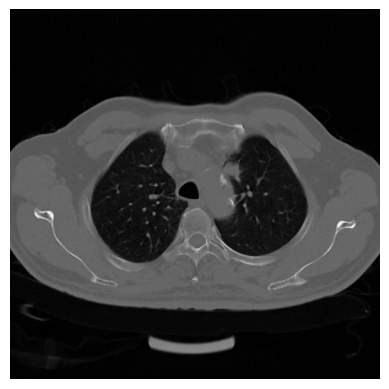

INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


100%|██████████| 2/2 [00:00<00:00, 2163.13it/s]


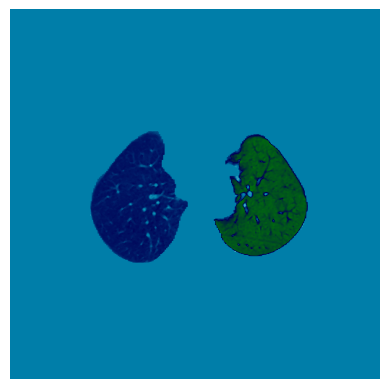

(array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ..., 28,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint16),
 4)

In [73]:
dataset = DICOMDataset(root_dir='../IMAGES/DICOM_SUPPORT/', transform=None)

dataset.__getitem__(32)